In [1]:
import pandas as pd
from googleapiclient.discovery import build
from dotenv import load_dotenv
import os
load_dotenv()
# replace with your own API key
API_KEY = os.getenv('API_KEY')

def get_trending_videos(api_key, max_results=200):
    # build the youtube service
    youtube = build('youtube', 'v3', developerKey=api_key)

    # initialize the list to hold video details
    videos = []

    # fetch the most popular videos
    request = youtube.videos().list(
        part='snippet,contentDetails,statistics',
        chart='mostPopular',
        regionCode='IN',  
        maxResults=50
    )

    # paginate through the results if max_results > 50
    while request and len(videos) < max_results:
        response = request.execute()
        for item in response['items']:
            video_details = {
                'video_id': item['id'],
                'title': item['snippet']['title'],
                'description': item['snippet']['description'],
                'published_at': item['snippet']['publishedAt'],
                'channel_id': item['snippet']['channelId'],
                'channel_title': item['snippet']['channelTitle'],
                'category_id': item['snippet']['categoryId'],
                'category_name' : item['snippet']['title'],
                'tags': item['snippet'].get('tags', []),
                'duration': item['contentDetails']['duration'],
                'definition': item['contentDetails']['definition'],
                'caption': item['contentDetails'].get('caption', 'false'),
                'view_count': item['statistics'].get('viewCount', 0),
                'like_count': item['statistics'].get('likeCount', 0),
                'dislike_count': item['statistics'].get('dislikeCount', 0),
                'favorite_count': item['statistics'].get('favoriteCount', 0),
                'comment_count': item['statistics'].get('commentCount', 0)
            }
            videos.append(video_details)

        # get the next page token
        request = youtube.videos().list_next(request, response)

    return videos[:max_results]

def save_to_csv(data, filename):
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)

def main():
    trending_videos = get_trending_videos(API_KEY)
    filename = 'trending_videos.csv'
    save_to_csv(trending_videos, filename)
    print(f'Trending videos saved to {filename}')
main()

Trending videos saved to trending_videos.csv


In [2]:
import pandas as pd

trending_videos = pd.read_csv('trending_videos.csv')
print(trending_videos.head())

      video_id                                              title  \
0  as86Klk5qUE  Tamilaga Vettri Kazhagam: Flag Anthem | தமிழக ...   
1  h63m54WmLTM  Durability Test of Ather 450X - Will It Surviv...   
2  2RCo2j7a1f4  TVK Flag | Actor Vijay Speech | Tamizhaga Vetr...   
3  K7HdCZkf-bU  पटवारी PATWARI Part-1 | Uttar kumar new movie ...   
4  81ktpexWqyI  पटवारी PATWARI Part-2 | Uttar kumar new movie ...   

                                         description          published_at  \
0  #TVKFlagAnthem\n#ThalaivarVijay \n\nநாடெங்கும்...  2024-08-22T04:06:48Z   
1  SUBSCRIBE: https://youtube.com/MRINDIANHACKER?...  2024-08-22T07:30:14Z   
2  #thalapathyvijayspeech #tvk #vijay #tvkflag #s...  2024-08-22T04:34:40Z   
3  Banner - RAJLAXMI Movies\n\nFilm Title - Patwa...  2024-08-23T03:30:14Z   
4  Banner - RAJLAXMI Movies\n\nFilm Title - Patwa...  2024-08-23T04:30:03Z   

                 channel_id             channel_title  category_id  \
0  UCGZHc6wDJFjeNAAJhatSDXg  Tamilaga Vettri K

In [3]:
# check for missing values
missing_values = trending_videos.isnull().sum()

# display data types
data_types = trending_videos.dtypes

missing_values, data_types

(video_id          0
 title             0
 description       2
 published_at      0
 channel_id        0
 channel_title     0
 category_id       0
 category_name     0
 tags              0
 duration          0
 definition        0
 caption           0
 view_count        0
 like_count        0
 dislike_count     0
 favorite_count    0
 comment_count     0
 dtype: int64,
 video_id          object
 title             object
 description       object
 published_at      object
 channel_id        object
 channel_title     object
 category_id        int64
 category_name     object
 tags              object
 duration          object
 definition        object
 caption             bool
 view_count         int64
 like_count         int64
 dislike_count      int64
 favorite_count     int64
 comment_count      int64
 dtype: object)

In [4]:
# fill missing descriptions with "No description"
trending_videos.fillna({'description': 'No description'}, inplace=True)

# convert `published_at` to datetime
trending_videos['published_at'] = pd.to_datetime(trending_videos['published_at'])

# convert tags from string representation of list to actual list
trending_videos['tags'] = trending_videos['tags'].apply(lambda x: eval(x) if isinstance(x, str) else x)

In [5]:
# descriptive statistics
descriptive_stats = trending_videos[['view_count', 'like_count', 'dislike_count', 'comment_count']].describe()

descriptive_stats

,view_count,like_count,dislike_count,comment_count
count,1.400000e+02,1.400000e+02,140.0,140.000000
mean,2.469393e+06,9.870064e+04,0.0,3615.657143
std,8.220720e+06,3.246502e+05,0.0,8888.066366
min,7.484800e+04,0.000000e+00,0.0,6.000000
25%,4.038225e+05,8.400750e+03,0.0,250.750000
50%,6.835845e+05,2.150300e+04,0.0,831.000000
75%,1.846987e+06,7.012250e+04,0.0,2889.000000
max,8.454596e+07,3.454875e+06,0.0,62611.000000


In [6]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Create a 1x3 subplot
fig = make_subplots(rows=1, cols=3, subplot_titles=("View Count Distribution", "Like Count Distribution", "Comment Count Distribution"))

# View Count Distribution
fig.add_trace(
    go.Histogram(x=trending_videos['view_count'], nbinsx=30, marker_color='blue', name='View Count', histnorm='density'),
    row=1, col=1
)
# Add KDE for View Count
fig.add_trace(
    go.Scatter(x=trending_videos['view_count'], y=px.histogram(trending_videos, x='view_count', nbins=30, histnorm='density').data[0]['y'], mode='lines', line=dict(color='blue'), showlegend=False),
    row=1, col=1
)

# Like Count Distribution
fig.add_trace(
    go.Histogram(x=trending_videos['like_count'], nbinsx=30, marker_color='green', name='Like Count', histnorm='density'),
    row=1, col=2
)
# Add KDE for Like Count
fig.add_trace(
    go.Scatter(x=trending_videos['like_count'], y=px.histogram(trending_videos, x='like_count', nbins=30, histnorm='density').data[0]['y'], mode='lines', line=dict(color='green'), showlegend=False),
    row=1, col=2
)

# Comment Count Distribution
fig.add_trace(
    go.Histogram(x=trending_videos['comment_count'], nbinsx=30, marker_color='red', name='Comment Count', histnorm='density'),
    row=1, col=3
)
# Add KDE for Comment Count
fig.add_trace(
    go.Scatter(x=trending_videos['comment_count'], y=px.histogram(trending_videos, x='comment_count', nbins=30, histnorm='density').data[0]['y'], mode='lines', line=dict(color='red'), showlegend=False),
    row=1, col=3
)

# Update layout
fig.update_layout(
    title_text="Distributions of View Count, Like Count, and Comment Count",
    height=500, width=1200,
    showlegend=False,
    xaxis_title_text='Count', yaxis_title_text='Frequency',
)

# Update axis titles for each subplot
fig.update_xaxes(title_text="View Count", row=1, col=1)
fig.update_xaxes(title_text="Like Count", row=1, col=2)
fig.update_xaxes(title_text="Comment Count", row=1, col=3)

fig.update_yaxes(title_text="Frequency", row=1, col=1)
fig.update_yaxes(title_text="Frequency", row=1, col=2)
fig.update_yaxes(title_text="Frequency", row=1, col=3)

fig.show()


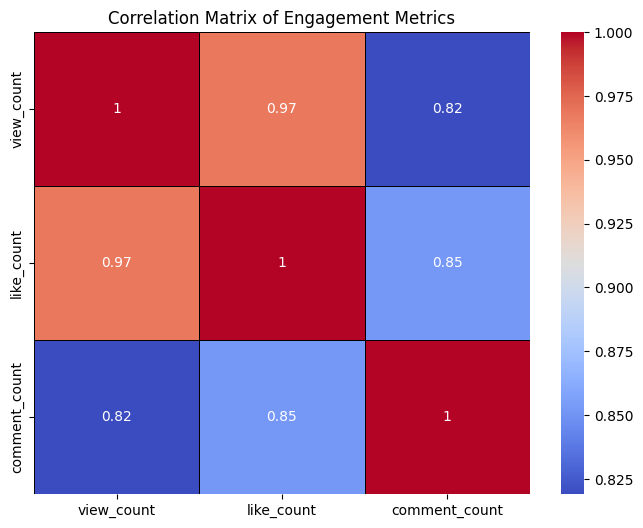

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
# correlation matrix
correlation_matrix = trending_videos[['view_count', 'like_count', 'comment_count']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, linecolor='black')
plt.title('Correlation Matrix of Engagement Metrics')
plt.show()

In [8]:

youtube = build('youtube', 'v3', developerKey=API_KEY)

def get_category_mapping():
    request = youtube.videoCategories().list(
        part='snippet',
        regionCode='IN'
    )
    response = request.execute()
    category_mapping = {}
    for item in response['items']:
        category_id = int(item['id'])
        category_name = item['snippet']['title']
        category_mapping[category_id] = category_name
    return category_mapping

# get the category mapping
category_mapping = get_category_mapping()
print(category_mapping)

{1: 'Film & Animation', 2: 'Autos & Vehicles', 10: 'Music', 15: 'Pets & Animals', 17: 'Sports', 18: 'Short Movies', 19: 'Travel & Events', 20: 'Gaming', 21: 'Videoblogging', 22: 'People & Blogs', 23: 'Comedy', 24: 'Entertainment', 25: 'News & Politics', 26: 'Howto & Style', 27: 'Education', 28: 'Science & Technology', 30: 'Movies', 31: 'Anime/Animation', 32: 'Action/Adventure', 33: 'Classics', 34: 'Comedy', 35: 'Documentary', 36: 'Drama', 37: 'Family', 38: 'Foreign', 39: 'Horror', 40: 'Sci-Fi/Fantasy', 41: 'Thriller', 42: 'Shorts', 43: 'Shows', 44: 'Trailers'}


In [9]:
# Map category_id to category_name
trending_videos['category_name'] = trending_videos['category_id'].map(category_mapping)

# Create a bar chart for category counts
category_counts = trending_videos['category_name'].value_counts()

fig = px.bar(
    category_counts,
    x=category_counts.values,
    y=category_counts.index,
    orientation='h',
    color=category_counts.index,
    color_discrete_sequence=px.colors.sequential.Viridis,
    labels={'x': 'Number of Videos', 'y': 'Category'},
    title='Number of Trending Videos by Category',
)

# Update layout for better appearance
fig.update_layout(
    xaxis_title="Number of Videos",
    yaxis_title="Category",
    yaxis=dict(categoryorder='total ascending'),
    width=800, height=600
)

fig.show()
